In [31]:
import contextlib
import torch
import warnings
from typing import Union, Any, Optional
import numpy as np

import os
import zipfile
import json
import copy
from typing import Optional, List, Tuple, Dict
import PIL
from torch import nn

from torch.utils.data import DataLoader, Dataset

from helper import show_one
from dataset_creation import StyleDataset
import torchvision

import matplotlib.pyplot as plt

In [2]:
@contextlib.contextmanager
def supress_tracer_warnings():
    flt  = ('ignore', None, torch.jit.TracerWarning, None, 0)
    warnings.filters.insert(0, flt)
    yield
    warnings.filters.remove(flt)

In [3]:
def assert_shape(tensor, ref_shape):
    if tensor.ndim != len(ref_shape): raise AssertionError(f'Wrong number of dimensions: got {tensor.ndim}, expected {len(ref_shape)}')

    for idx, (size, ref_size) in enumerate(zip(tensor.shape, ref_shape)):
        if ref_size is None: pass
        elif isinstance(ref_size, torch.Tensor):
            with supress_tracer_warnings():
                torch._assert(
                    torch.equal(torch.as_tensor(size), ref_size), f'Wrong size for dimension {idx}'
                )
        elif isinstance(size, torch.Tensor):
            with supress_tracer_warnings():
                torch.equal(
                    torch._assert(size, torch.as_tensor(ref_shape)), f'Wrong size for dimension {idx}'
                )
        elif size != ref_size:
            raise AssertionError(f'Wrong size for dimension {idx}: got {size}, expected {ref_size}')

assert_shape(torch.tensor([[2,4]]), [1,2])

In [4]:
def is_list_of_str(arr: Any):
    if arr is None: return None
    is_list = isinstance(arr, list) or isinstance(arr, np.ndarray) or isinstance(arr, tuple)
    is_str = isinstance(arr[0], str)
    return is_list and is_str

is_list_of_str([1]), is_list_of_str(['a',1])

(False, True)

In [5]:
def normalise_2nd_moment(x: torch.Tensor, dim: int = 1, eps: float = 1e-8):
    a = x.square().mean(dim=dim, keepdim=True) + eps
    a = a.rsqrt()
    a = x * a
    return x

normalise_2nd_moment(torch.rand(2,4))

tensor([[0.5727, 0.4702, 0.9870, 0.7513],
        [0.0813, 0.6756, 0.9439, 0.4234]])

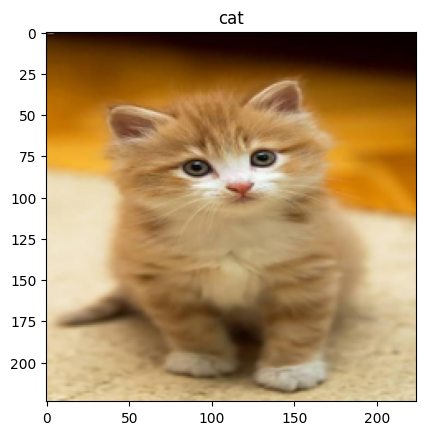

In [3]:
sd = StyleDataset(path="/Users/mohamedmafaz/Desktop/StyleGAN-T/notebooks/Networks/dataset/", resolution=224)
sdl = DataLoader(sd, 3, shuffle=True)
out = next(iter(sdl))

show_one(out[0][1], out[1][1])

/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_7087/1916160703.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


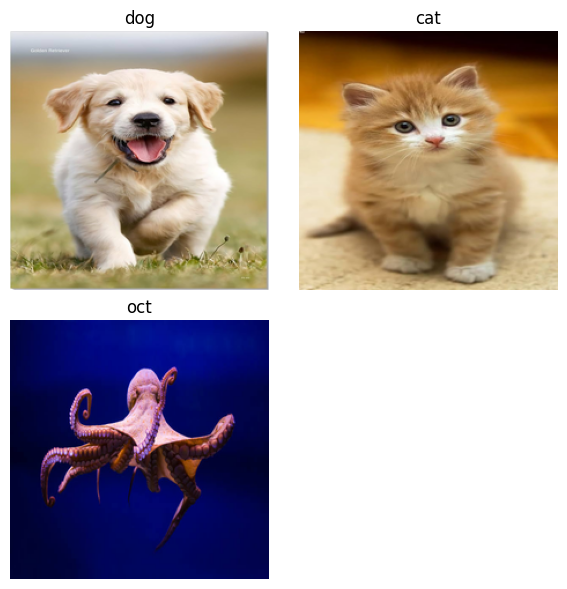

In [69]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

def save_image_grid(dl, name = "sample.png"):

    images, labels = next(iter(dl))

    num_grid = 2

    fig = plt.figure(figsize=(6, 6))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(num_grid, num_grid),
                    axes_pad=0.3,
                    )

    for ax, img, label in zip(grid, images, labels):
        img_np = img.detach().cpu().permute(1, 2, 0).numpy()

        ax.imshow(img_np)
        ax.axis("off")
        ax.set_title(label)

    for ax in grid[len(images):]:
        ax.axis("off")

    plt.tight_layout()
    plt.savefig(name)

save_image_grid(sdl)

In [56]:
len(images)

3

In [34]:
label

'dog'